In [4]:
from datasets import load_dataset
from PIL import Image
import torch
from transformers import AutoModelForCausalLM, GitProcessor
from tqdm import tqdm

ROOT = "./bgOn_heatmapOn_trajOn/"

train_ds = load_dataset("json", data_files="./image_description.json", split="train")#[:5%]
print(train_ds)

device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = ROOT+'checkpoint/checkpoint-300/'
processor = GitProcessor.from_pretrained("microsoft/git-base")#.to(device)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

yes_num = 0
pred_list = []
gt_list = []

for idx in tqdm(range(len(train_ds))):#4480
    idx = idx + 3
    img_path = ROOT + train_ds[idx]["image1"]
    image1 = Image.open(img_path)
    img_path = ROOT + train_ds[idx]["image2"]
    image2 = Image.open(img_path)
    print(img_path)

    image2 = image2.resize((image1.width, image1.height))
    # 創建拼接後的新圖片（寬度為兩張圖片寬度之和）
    new_width = image1.width
    new_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (new_width, new_height))

    # 將圖片粘貼到新圖片上
    concatenated_image.paste(image1, (0, 0))
    concatenated_image.paste(image2, (0, image1.height))

    #display(concatenated_image)

    inputs = processor(images=concatenated_image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=128)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_caption)
    break
    #print(train_ds[idx]["class"].lower())
    pred_list.append(generated_caption)
    gt_list.append(train_ds[idx]["class"].lower())
    if train_ds[idx]["class"].lower() == generated_caption:
        yes_num = yes_num+1
    #print("yes")

print(yes_num/len(train_ds))

Dataset({
    features: ['image1', 'image2', 'class'],
    num_rows: 4600
})


  0%|          | 0/4600 [00:00<?, ?it/s]

./bgOn_heatmapOn_trajOn/Pair-12-Coop-EYE_trial01_playerB.jpg


  0%|          | 0/4600 [00:00<?, ?it/s]

the answer is k, appearing 1 time ( s ). in this single - player mode, the observer ' s gaze is concentrated on multiple areas, including the target. the player ' s gaze is intensely focused on the target, indicating effective target identification.
0.0


## concate methods

In [4]:
from datasets import load_dataset
from PIL import Image
import torch
from transformers import AutoModelForCausalLM, GitProcessor
from tqdm import tqdm

ROOT = "./bgOff_heatmapOn_trajOn/"

train_ds = load_dataset("json", data_files="./image_gt_test.json", split="train")#[:5%]
print(train_ds)

device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = ROOT+'checkpoint/checkpoint-680/'
processor = GitProcessor.from_pretrained("microsoft/git-base")#.to(device)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

yes_num = 0
pred_list = []
gt_list = []

for idx in tqdm(range(len(train_ds))):#4480
    img_path = ROOT + train_ds[idx]["image1"]
    image1 = Image.open(img_path)
    img_path = ROOT + train_ds[idx]["image2"]
    image2 = Image.open(img_path)
    #print(img_path)

    image2 = image2.resize((image1.width, image1.height))
    # 創建拼接後的新圖片（寬度為兩張圖片寬度之和）
    new_width = image1.width
    new_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (new_width, new_height))

    # 將圖片粘貼到新圖片上
    concatenated_image.paste(image1, (0, 0))
    concatenated_image.paste(image2, (0, image1.height))

    #display(concatenated_image)

    inputs = processor(images=concatenated_image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=128)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    #print(generated_caption)
    #print(train_ds[idx]["class"].lower())
    pred_list.append(generated_caption)
    gt_list.append(train_ds[idx]["class"].lower())
    if train_ds[idx]["class"].lower() == generated_caption:
        yes_num = yes_num+1
    #print("yes")

print(yes_num/len(train_ds))

Dataset({
    features: ['image1', 'image2', 'class'],
    num_rows: 800
})


100%|██████████| 800/800 [01:28<00:00,  9.08it/s]

0.79375


In [5]:
from evaluate import load
import torch

# Load the metrics
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

label_mapping = {"single": 0, "cooperation": 1, "competition": 2}

encoded_labels = [label_mapping.get(label, 4) for label in gt_list]
encoded_predictions = [label_mapping.get(pred, 4) for pred in pred_list]

accuracy = accuracy_metric.compute(predictions=encoded_predictions, references=encoded_labels)
precision = precision_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")
recall = recall_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")
f1_score = f1_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")

print(accuracy)
print(precision)
print(recall)
print(f1_score)



{'accuracy': 0.79375}
{'precision': 0.7987968508298842}
{'recall': 0.79375}
{'f1': 0.7855591569843199}


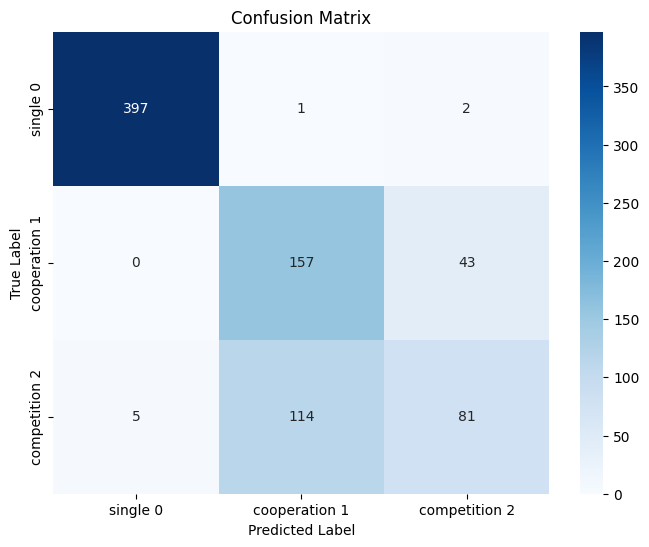

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 範例資料：真實標籤和預測標籤
y_true = encoded_labels    # 真實標籤
y_pred = encoded_predictions  # 預測標籤

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)

# 設定標籤名稱
labels = ['single 0', 'cooperation 1', 'competition 2']

# 繪製混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [1]:
from datasets import load_dataset
from PIL import Image
import torch
from transformers import AutoModelForCausalLM, GitProcessor
from tqdm import tqdm



train_ds = load_dataset("json", data_files="./image_gt.json", split="train")#[:5%]
print(train_ds)

device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = './vqa_check/checkpoint-1370/'
processor = GitProcessor.from_pretrained("microsoft/git-base")#.to(device)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

yes_num = 0
pred_list = []
gt_list = []

for idx in tqdm(range(len(train_ds))):#4480
    img_path = "./heatmapOn_trajOn/" + train_ds[idx]["image1"]
    image1 = Image.open(img_path)
    img_path = "./heatmapOn_trajOn/" + train_ds[idx]["image2"]
    image2 = Image.open(img_path)
    #print(img_path)

    image2 = image2.resize((image1.width, image1.height))
    black_image = Image.new('RGB', (image1.width, image1.height), color=(0, 0, 0))
    
    #display(image1)
    #display(image2)

    #inputs = processor(images=[image1, black_image, black_image, image2, black_image, black_image], return_tensors="pt").to(device)
    inputs = processor(images=[image1, image2], return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=32)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    #print(train_ds[idx]["class"].lower(), generated_caption)
    #print(train_ds[idx]["class"].lower())
    pred_list.append(generated_caption)
    gt_list.append(train_ds[idx]["class"].lower())
    if train_ds[idx]["class"].lower() == generated_caption:
        yes_num = yes_num+1
    #print("yes")

print(yes_num/len(train_ds))

Dataset({
    features: ['image1', 'image2', 'class'],
    num_rows: 4480
})


100%|██████████| 4480/4480 [06:45<00:00, 11.04it/s]

0.465625


In [2]:
from evaluate import load
import torch

# Load the metrics
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

label_mapping = {"single": 0, "cooperation": 1, "competition": 2}

encoded_labels = [label_mapping.get(label, 4) for label in gt_list]
encoded_predictions = [label_mapping.get(pred, 4) for pred in pred_list]

accuracy = accuracy_metric.compute(predictions=encoded_predictions, references=encoded_labels)
precision = precision_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")
recall = recall_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")
f1_score = f1_metric.compute(predictions=encoded_predictions, references=encoded_labels, average="weighted")

print(accuracy)
print(precision)
print(recall)
print(f1_score)



{'accuracy': 0.465625}
{'precision': 0.33358250336552575}
{'recall': 0.465625}
{'f1': 0.3863523524301393}


/home/cnelabai/anaconda3/envs/hugging/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### atteion

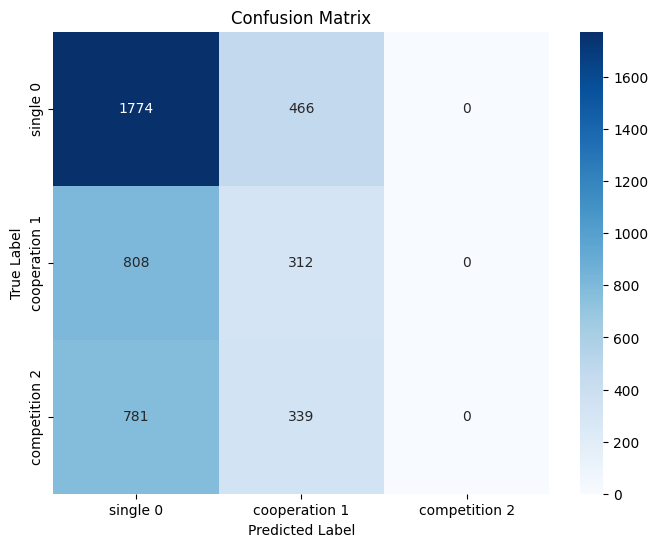

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 範例資料：真實標籤和預測標籤
y_true = encoded_labels    # 真實標籤
y_pred = encoded_predictions  # 預測標籤

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)

# 設定標籤名稱
labels = ['single 0', 'cooperation 1', 'competition 2']

# 繪製混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [2]:
from transformers import file_utils
print(file_utils.default_cache_path)

/home/cnelabai/.cache/huggingface/hub
